In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
import official.nlp.bert as bert

from official.nlp.bert.tokenization import FullTokenizer

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0],True)

2022-07-30 11:31:31.083860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 11:31:31.148833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 11:31:31.149294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [4]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

2022-07-30 11:31:31.568029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-30 11:31:31.611314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 11:31:31.612492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 11:31:31.613537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [6]:
glue_train = glue['train']

for key, value in glue_train.items():
    print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


In [7]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [8]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [9]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [10]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [11]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s.numpy()))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [12]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


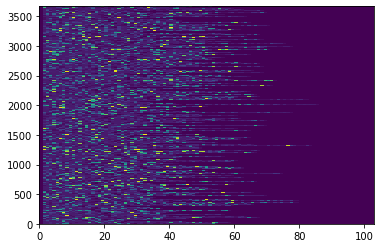

In [13]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

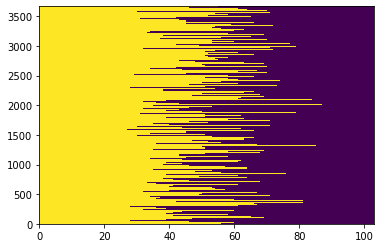

In [14]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

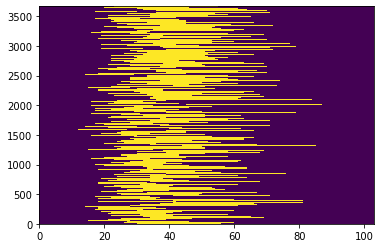

In [15]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [16]:
def encode_sentence(s, tokenizer):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
    num_examples = len(glue_dict["sentence1"])

    sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
    for s in np.array(glue_dict["sentence1"])])
    sentence2 = tf.ragged.constant([
        encode_sentence(s, tokenizer)
        for s in np.array(glue_dict["sentence2"])])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [17]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [18]:
for key, value in glue_train.items():
    print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


In [19]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [20]:
from official.nlp.bert.bert_models import classifier_model

In [21]:
bert_classifier, bert_encoder = classifier_model(
    bert_config, num_labels=2)

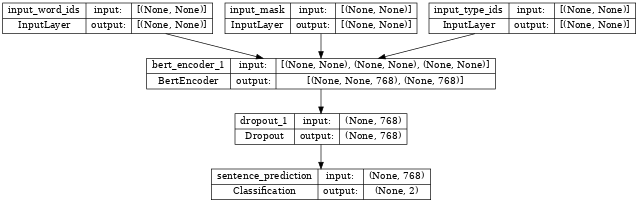

In [22]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [23]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.01970289, -0.15883031],
       [-0.1291421 , -0.13205406],
       [-0.08387764, -0.25150454],
       [-0.04919283, -0.12287755],
       [ 0.25419152, -0.18349685],
       [ 0.15831922, -0.07533481],
       [-0.14916839,  0.00376453],
       [-0.24515596, -0.14875017],
       [-0.0719928 , -0.15859988],
       [ 0.16081768, -0.33366543]], dtype=float32)

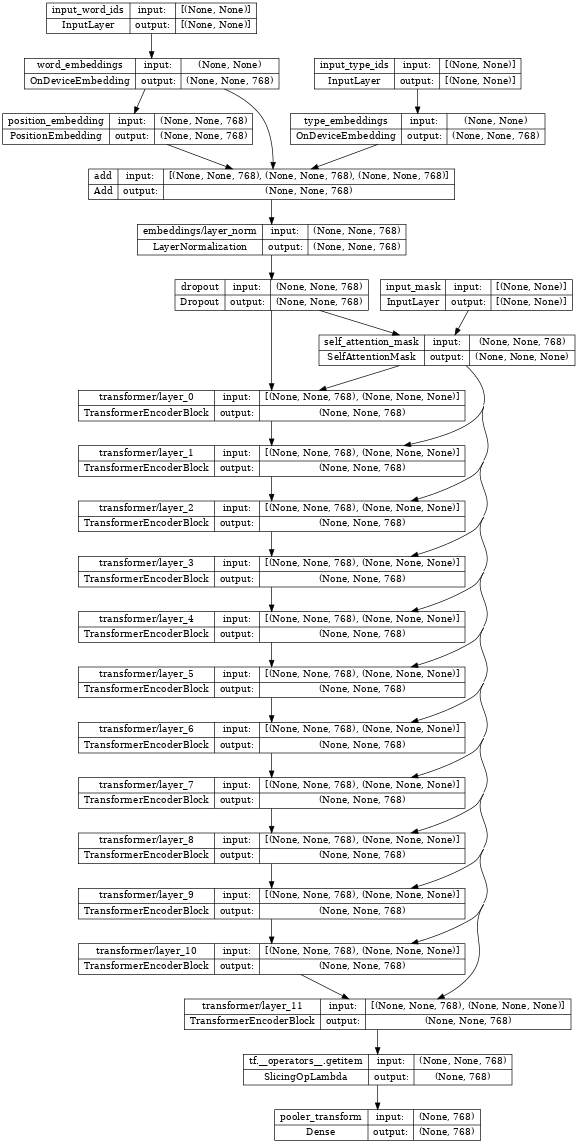

In [24]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [25]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [26]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [27]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [28]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3


2022-07-30 11:48:34.998709: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.66MiB (rounded to 10125312)requested by op bert_classifier/bert_encoder_1/transformer/layer_5/self_attention_layer_norm/batchnorm/mul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-30 11:48:34.998838: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-07-30 11:48:34.998879: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 196, Chunks in use: 195. 49.0KiB allocated for chunks. 48.8KiB in use in bin. 1.2KiB client-requested in use in bin.
2022-07-30 11:48:34.998902: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bi

ResourceExhaustedError: Graph execution error:

Detected at node 'bert_classifier/bert_encoder_1/transformer/layer_5/self_attention_layer_norm/batchnorm/mul_1' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_14268/2552906924.py", line 9, in <cell line: 9>
      bert_classifier.fit(
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/official/nlp/keras_nlp/layers/transformer_encoder_block.py", line 257, in call
      if self._norm_first:
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/official/nlp/keras_nlp/layers/transformer_encoder_block.py", line 260, in call
      attention_output = self._attention_layer_norm(target_tensor +
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/joker/.virtualenvs/tensorflow_lastest/lib/python3.9/site-packages/keras/layers/normalization/layer_normalization.py", line 275, in call
      outputs = tf.nn.batch_normalization(
Node: 'bert_classifier/bert_encoder_1/transformer/layer_5/self_attention_layer_norm/batchnorm/mul_1'
failed to allocate memory
	 [[{{node bert_classifier/bert_encoder_1/transformer/layer_5/self_attention_layer_norm/batchnorm/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_54220]

In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [ ]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

In [ ]:
np.array(info.features['label'].names)[result]

In [ ]:
export_dir='../models/bert_fine/'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())